# Simulate trajectories and check the cost functions 

In [ ]:
from mhe_solver import MHE
import numpy as np
import matplotlib.pyplot as plt 
from user_defined_reactor import ode_reactor, h_reactor, c_reactor, u_reactor 
from user_defined_reactor import nx, nu, n_par, nc, ny, x_min, x_max, p_min, p_max

Q, R = np.eye(nx), 1e6 * np.eye(ny)
Qf, Pf = np.eye(nx), np.eye(n_par)
dt, rho_c, q, N_O =0.005, 1e2, 15, 12

mhe = MHE(nx=nx, nu=nu, 
          n_par=n_par,
          nc=nc, ny=ny,
          x_min= x_min, 
          x_max=x_max,
          p_min=p_min, 
          p_max=p_max,
          ode=ode_reactor, 
          meas_func=h_reactor,
          constraints=c_reactor,
          u_from_y=u_reactor,
          dt=dt, N_O=N_O, q=q,
          Q=Q, R=R, Qf=Qf, Pf=Pf, 
          rho_c=rho_c, max_iter=500)

# Simulate the observer's behavior

## Simulate the process

In [5]:
# Generate the scenario 
#------------------------------------------------------
Nsim = 4001
p = np.array([0.16])
x0 = np.array([3,1])
t_sim = (Nsim+1) * mhe.dt
U_sim = np.array([0]*Nsim)
p_sim = np.array([0.16])
t, X, Y = mhe.simulate(x0, U_sim, p_sim)
#------
if 0:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(t, X)
    plt.xlim([t.min(), t.max()])
    plt.legend([f'x_{i+1}' for i in range(mhe.nx)]);
    plt.title("States evolutions")
    plt.subplot(1,2,2)
    ones = np.ones(len(t)).reshape(-1,1);
    plt.plot(t, ones @ p_sim.reshape(1,-1));
    plt.legend([f'p_{i+1}' for i in range(mhe.np)]);
    plt.title('Parameters evolution')

## Simulate the observers behavior

In [6]:
#x_hat_0 = 1.5*np.ones(mhe.nx)
x_hat_0 = np.diag([1.5,0.2]) @ x0
#p_hat_0 = np.diag(0.25*np.random.randn(mhe.np)) @ p_sim
p_hat_0 = 1.8 * p
lam = 0.2
noise = 0.02
# In case fast gradient is used
gam, c, Niter = 0.1, 0.9, 10000
option = 'ipopt'
Y_noisy = Y + noise * np.random.randn(*Y.shape)
R = mhe.simulate_mhe(t, X, Y_noisy, x_hat_0, p_hat_0,
                     lam, gam=gam, c=c, 
                     Niter=Niter, option=option)

X_hat, P_hat, t_cpu, cpu = R[0], R[1], R[2], R[3]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      114

Total number of variables............................:       27
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       27
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

Text(0.5, 1.0, 'cpu vs available cpu / solver=ipopt')

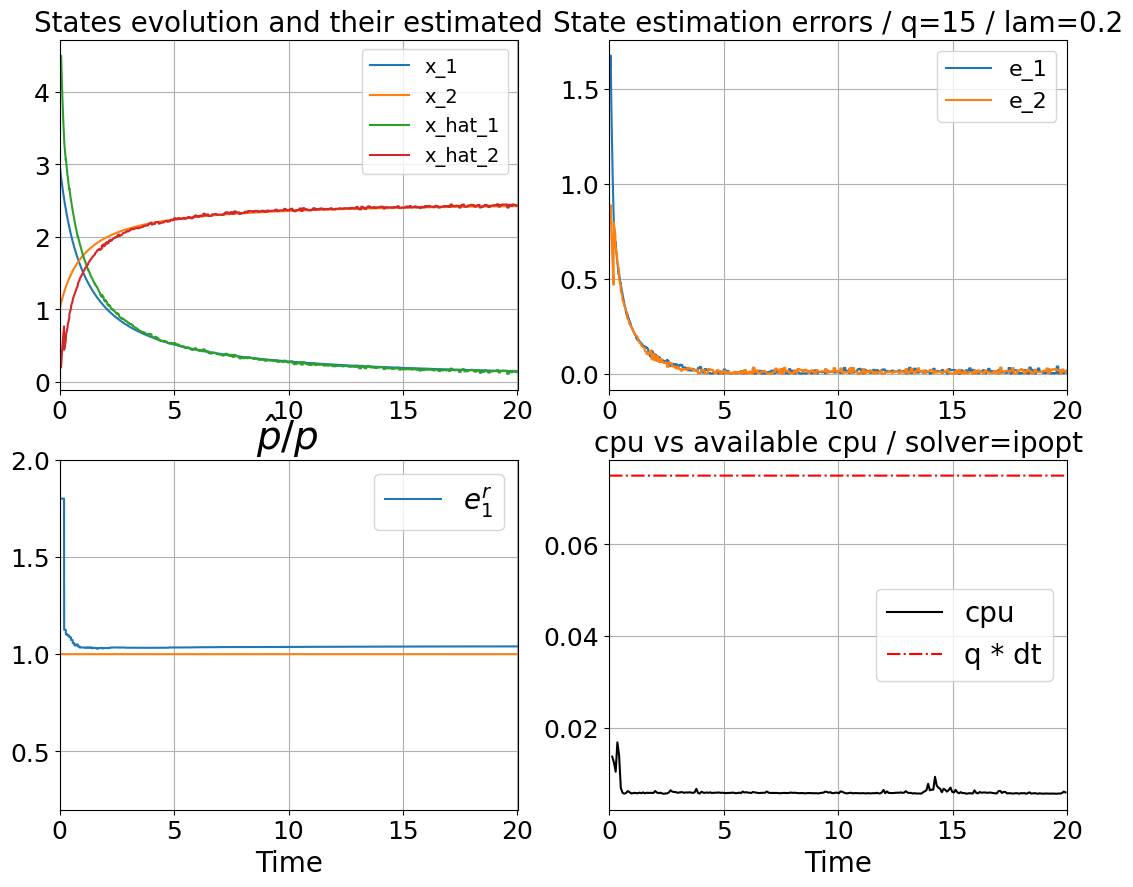

In [ ]:
plt.figure(figsize=(13,10))
#--------
plt.subplot(2,2,1)
plt.plot(t,X)
plt.plot(t, X_hat)
plt.legend([f'x_{i+1}' for i in range(mhe.nx)] + 
           [f'x_hat_{i+1}' for i in range(mhe.nx)], fontsize=14)
plt.title('States evolution and their estimated', fontsize=20)
#plt.xlabel('Time', fontsize=20)
plt.tick_params(axis='x', which='both', labelsize=18)
plt.tick_params(axis='y', which='both', labelsize=18)
plt.xlim([t.min(), t.max()])
plt.grid(True)
#--------
plt.subplot(2,2,2)
plt.plot(t, abs(X-X_hat))
plt.legend([f"e_{i+1}" for i in range(mhe.nx)], fontsize=16)
plt.title(f'State estimation errors / q={mhe.q} / lam={lam}', fontsize=20)
plt.tick_params(axis='x', which='both', labelsize=18)
plt.tick_params(axis='y', which='both', labelsize=18)
#plt.xlabel('Time', fontsize=20)
plt.xlim([t.min(), t.max()])
plt.grid(True)
#--------
plt.subplot(2,2,3)
plt.plot(t, np.divide(P_hat, p))
plt.plot(t, np.ones_like(t))
plt.title(fr"$\hat p / p$ ", fontsize=28)
plt.tick_params(axis='x', which='both', labelsize=18)
plt.tick_params(axis='y', which='both', labelsize=18)
plt.xlim([t.min(), t.max()])
plt.ylim([0.2, 2])
plt.xlabel('Time', fontsize=20)
plt.legend([rf'$e^r_{i+1}$' for i in range(mhe.np)], fontsize=20)
plt.grid(True)
#--------
plt.subplot(2,2,4)
plt.plot(t_cpu, cpu, 'k-')
plt.xlim([t.min(), t.max()])
plt.plot(t, np.ones(len(t))*mhe.dt * mhe.q, 'r-.')
plt.tick_params(axis='x', which='both', labelsize=18)
plt.tick_params(axis='y', which='both', labelsize=18)
plt.legend(['cpu', r'q * dt'], fontsize=20)
plt.grid(True)
plt.xlabel('Time', fontsize=20)
plt.title(f'cpu vs available cpu / solver={option}', fontsize=20)
#-------
plt.show()